In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter



## Loading the Dataset

We load the drug review dataset from an Excel file using `pandas.read_excel()`.

In [2]:
main=pd.read_excel("drugsCom_raw.xlsx")

In [3]:
main["condition"]

0         Left Ventricular Dysfunction
1                                 ADHD
2                        Birth Control
3                        Birth Control
4                    Opiate Dependence
                      ...             
161292              Alcohol Dependence
161293                 Nausea/Vomiting
161294            Rheumatoid Arthritis
161295             Underactive Thyroid
161296           Constipation, Chronic
Name: condition, Length: 161297, dtype: object

In [4]:
main.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


We filter the dataset to include only reviews related to the following conditions:
- Depression
- High Blood Pressure
- Diabetes, Type 2

In [5]:
df=main[main["condition"].isin(["Depression","High Blood Pressure","Diabetes, Type 2"])]

In [6]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,2017-03-09,54
31,96233,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8,2011-05-07,3
44,121333,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4,2016-04-27,3
50,156544,Dulaglutide,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l...",10,2017-10-24,24
67,131909,Effexor XR,Depression,"""This medicine saved my life. I was at my wits...",10,2013-06-20,166


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13944 entries, 11 to 161290
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   13944 non-null  int64         
 1   drugName     13944 non-null  object        
 2   condition    13944 non-null  object        
 3   review       13944 non-null  object        
 4   rating       13944 non-null  int64         
 5   date         13944 non-null  datetime64[ns]
 6   usefulCount  13944 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 871.5+ KB


In [8]:
df.isnull().sum()

Unnamed: 0     0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [9]:
df["condition"].unique()

array(['Depression', 'Diabetes, Type 2', 'High Blood Pressure'],
      dtype=object)

In this step we check number of reviews available for each selected medical condition

In [10]:
df["condition"].value_counts()

Depression             9069
Diabetes, Type 2       2554
High Blood Pressure    2321
Name: condition, dtype: int64

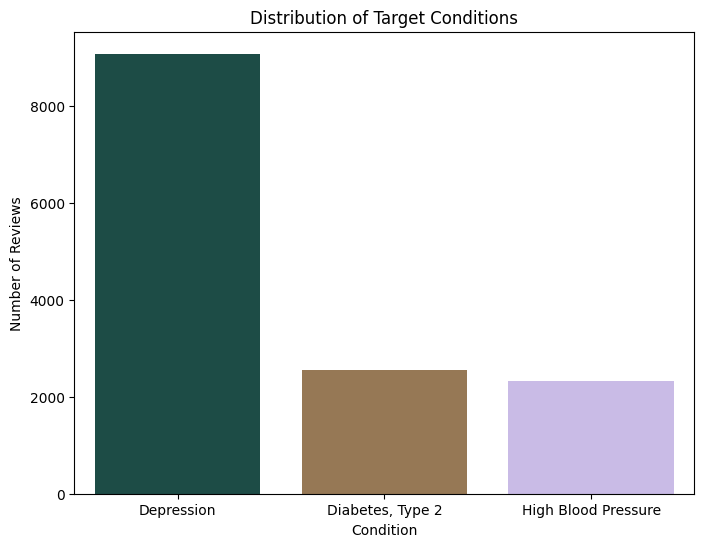

In [11]:
plt.figure(figsize=(8,6))
sns.barplot(df["condition"].value_counts(),palette="cubehelix")
plt.title("Distribution of Target Conditions")
plt.xlabel('Condition')
plt.ylabel('Number of Reviews')
plt.show()

average rating  for each drug

In [12]:
df.groupby("drugName")["rating"].mean()

drugName
Abilify         6.591549
Acarbose        1.000000
Acebutolol      9.500000
ActoPlus Met    6.500000
Actos           4.863636
                  ...   
Zestoretic      8.333333
Zestril         6.000000
Ziac            5.700000
Zoloft          7.281139
Zyprexa         5.785714
Name: rating, Length: 334, dtype: float64

average rating for each condition

In [13]:
df.groupby("condition")["rating"].mean()

condition
Depression             7.099460
Diabetes, Type 2       6.611981
High Blood Pressure    6.214994
Name: rating, dtype: float64

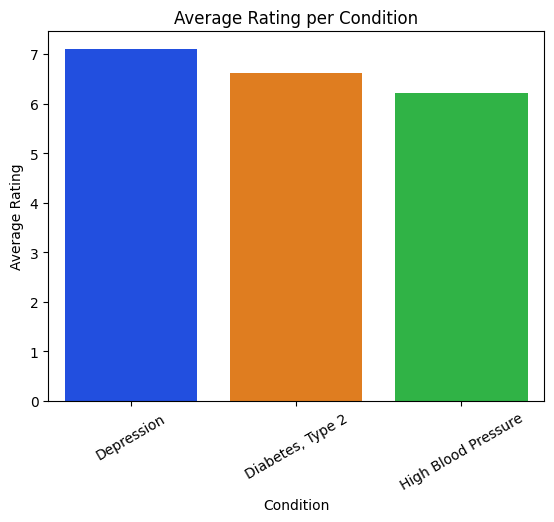

In [14]:

groprating=df.groupby("condition")["rating"].mean().reset_index()
sns.barplot(data=groprating, x='condition', y='rating', palette='bright')

plt.title("Average Rating per Condition")
plt.xlabel("Condition")
plt.ylabel("Average Rating")
plt.xticks(rotation=30)
plt.show()

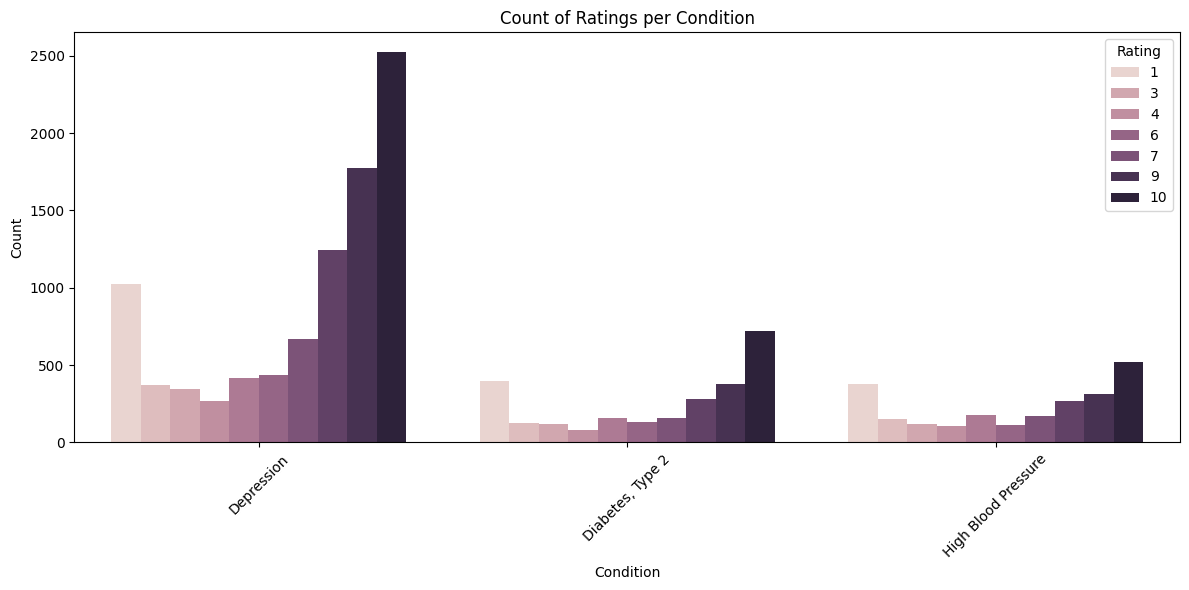

In [15]:

grouped = df.groupby(["condition", "rating"]).size().reset_index(name="count")
plt.figure(figsize=(12,6))
sns.barplot(data=grouped, x="condition", y="count", hue="rating")

# Formatting
plt.title("Count of Ratings per Condition")
plt.xlabel("Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Rating")
plt.tight_layout()
plt.show()

Drug and Condition Combinations


In [16]:
df.groupby(["drugName","condition"]).size().reset_index(name="count")

,drugName,condition,count
0,Abilify,Depression,142
1,Acarbose,"Diabetes, Type 2",1
2,Acebutolol,High Blood Pressure,2
3,ActoPlus Met,"Diabetes, Type 2",4
4,Actos,"Diabetes, Type 2",22
...,...,...,...
329,Zestoretic,High Blood Pressure,3
330,Zestril,High Blood Pressure,7
331,Ziac,High Blood Pressure,10
332,Zoloft,Depression,281


Top 3 Drugs per Condition

In [17]:
df.groupby(['condition', 'drugName']).size().sort_values(ascending=False).groupby(level=0).head(3)


condition            drugName   
Depression           Bupropion      549
                     Sertraline     459
                     Venlafaxine    437
Diabetes, Type 2     Liraglutide    270
High Blood Pressure  Lisinopril     264
Diabetes, Type 2     Victoza        255
                     Dulaglutide    231
High Blood Pressure  Losartan       166
                     Amlodipine     153
dtype: int64

 Distribution of Useful Counts per Condition

Text(0.5, 1.0, 'Distribution of Useful Counts by Condition')

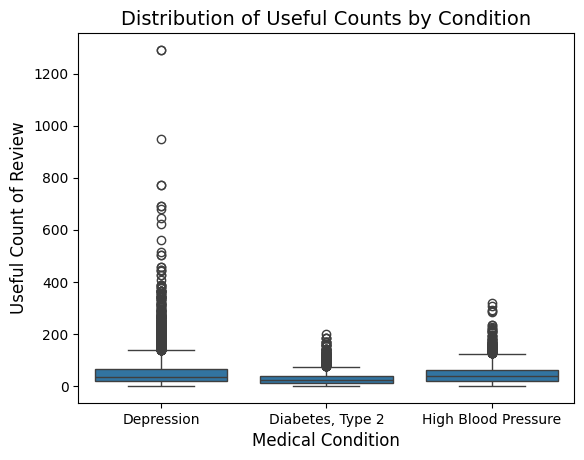

In [18]:
sns.boxplot(data=df, x='condition', y='usefulCount')
plt.xlabel('Medical Condition', fontsize=12)
plt.ylabel('Useful Count of Review', fontsize=12)
plt.title('Distribution of Useful Counts by Condition', fontsize=14)


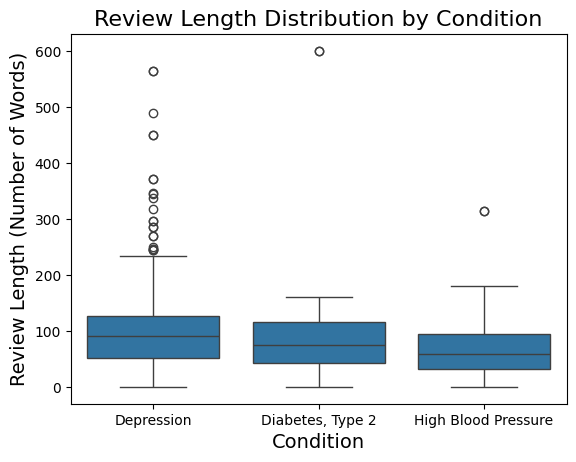

In [19]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
sns.boxplot(data=df, x='condition', y='review_length')
plt.title('Review Length Distribution by Condition', fontsize=16)
plt.xlabel('Condition', fontsize=14)
plt.ylabel('Review Length (Number of Words)', fontsize=14)
plt.show()

# Apply both stopword removal and special character cleaning 

In [20]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Setup tools
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_review_with_stop_and_stem(text):
    # Convert to string and lowercase
    text = str(text).lower()

    # Remove special characters and stopwords
    words = [word for word in text.split() if word not in stop]
    text_no_specials = re.sub(r'[^a-z0-9\s]', '', ' '.join(words))

    # Lemmatize and Stem each word
    processed_words = []
    for word in text_no_specials.split():
        # Lemmatize the word
        lemma = lemmatizer.lemmatize(word)
        # Stem the lemmatized word
        stemmed = stemmer.stem(lemma)
        processed_words.append(stemmed)

    return ' '.join(processed_words)

# Apply to DataFrame column
df['cleaned'] = df['review'].apply(clean_review_with_stop_and_stem)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91955\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91955\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\91955\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


join all reviews into a single text and convert to lowercase

In [21]:



all_reviews_text = ' '.join(df['cleaned']).lower()
words = re.findall(r'\b\w+\b', all_reviews_text)
words = [word for word in words if word not in stop]

word_counts = Counter(words)
top_common_words = word_counts.most_common(20)

top_words_df = pd.DataFrame(top_common_words, columns=['Word', 'Frequency'])


Top 20 Most Frequent Words (Overall)

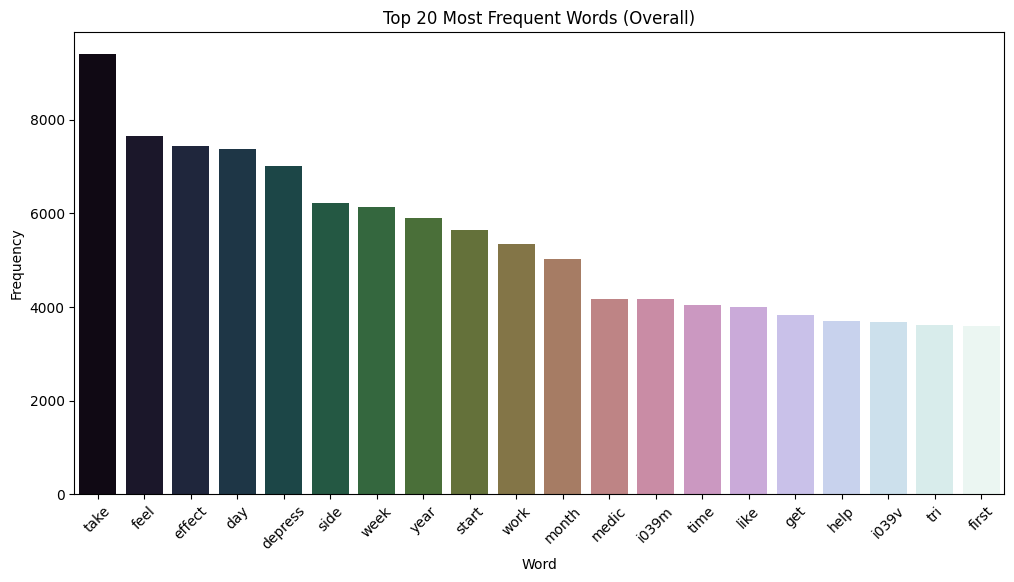

In [22]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Frequency', data=top_words_df, palette='cubehelix')
plt.title('Top 20 Most Frequent Words (Overall)')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


Filtering Rows Containing the Number "39" in Cleaned Text

In [23]:
df[df['cleaned'].str.contains(r'\b39\b', regex=True, na=False)].head()


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,review_length,cleaned
7006,181211,Prozac,Depression,"""I used prozac in the past for 3-9 months twic...",6,2017-03-24,31,128,i use prozac past 39 month twice side effect a...
11968,194244,Nebivolol,High Blood Pressure,"""I&#039;m 39 years old and I&#039;ve been expe...",8,2012-02-02,32,98,i039m 39 year old i039v experi high bp month 1...
12101,12117,Azilsartan medoxomil,High Blood Pressure,"""It is a bit pricey but has been very effectiv...",10,2013-06-07,24,66,it bit pricey effect keep blood pressur check ...
56518,86563,Invokana,"Diabetes, Type 2","""I am a 39 year old female who has had type tw...",10,2015-05-06,82,139,i 39 year old femal type two diabeti 15 year l...
71333,34355,Bystolic,High Blood Pressure,"""I&#039;m 39 years old and I&#039;ve been expe...",8,2012-02-02,32,98,i039m 39 year old i039v experi high bp month 1...


In [24]:
df[df['cleaned'].str.contains(r'\b39\b', regex=True, na=False)].shape


(16, 9)

After cleaning the text, some entries may have "I039m" or "39 years". We remove "I039m" because it's a mistake, but keep "39 years" because it’s useful.

In [25]:
df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([word for word in str(x).split() if not (('39' in word) and word != '39' and not word.isdigit())]))


After removing I039m

In [26]:
df[df['cleaned'].str.contains(r'\b39\b', regex=True, na=False)].head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,review_length,cleaned
7006,181211,Prozac,Depression,"""I used prozac in the past for 3-9 months twic...",6,2017-03-24,31,128,i use prozac past 39 month twice side effect a...
11968,194244,Nebivolol,High Blood Pressure,"""I&#039;m 39 years old and I&#039;ve been expe...",8,2012-02-02,32,98,39 year old experi high bp month 190140 effexo...
12101,12117,Azilsartan medoxomil,High Blood Pressure,"""It is a bit pricey but has been very effectiv...",10,2013-06-07,24,66,it bit pricey effect keep blood pressur check ...
56518,86563,Invokana,"Diabetes, Type 2","""I am a 39 year old female who has had type tw...",10,2015-05-06,82,139,i 39 year old femal type two diabeti 15 year l...
71333,34355,Bystolic,High Blood Pressure,"""I&#039;m 39 years old and I&#039;ve been expe...",8,2012-02-02,32,98,39 year old experi high bp month 190140 effexo...


In [27]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,review_length,cleaned
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,2017-03-09,54,80,i taken antidepress year improv mostli moder s...
31,96233,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8,2011-05-07,3,51,1 week zoloft anxieti mood swing take 50mg mor...
44,121333,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4,2016-04-27,3,136,my gp start venlafaxin yesterday help depress ...
50,156544,Dulaglutide,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l...",10,2017-10-24,24,147,hey guy 4 month sinc last post want give month...
67,131909,Effexor XR,Depression,"""This medicine saved my life. I was at my wits...",10,2013-06-20,166,106,thi medicin save life wit end antidepress read...


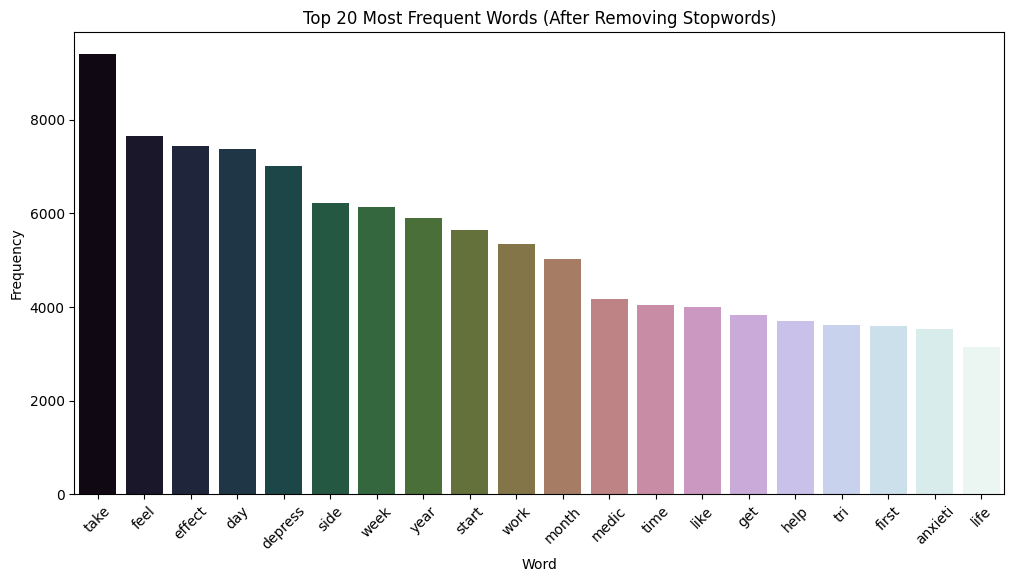

In [28]:
reviews_text_combined = ' '.join(df['cleaned']).lower()
extracted_words = re.findall(r'\b\w+\b', reviews_text_combined)
filtered_words = [word for word in extracted_words if word not in stop]

word_frequency = Counter(filtered_words)
top_words = word_frequency.most_common(20)

top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Frequency', data=top_words_df, palette='cubehelix')
plt.title('Top 20 Most Frequent Words (After Removing Stopwords)')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [29]:
# pip install vaderSentiment

Classifying Reviews as Positive or Negative:

In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()


def classify_sentiment(review):
  
    sentiment_score = analyzer.polarity_scores(review)['compound']
    
    # Classify the review based on the score
    if sentiment_score >= 0.05:
        return 'Positive'
    elif sentiment_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'


df['sentiment'] = df['cleaned'].apply(classify_sentiment)


df[['cleaned', 'sentiment']].head()


,cleaned,sentiment
11,i taken antidepress year improv mostli moder s...,Negative
31,1 week zoloft anxieti mood swing take 50mg mor...,Positive
44,my gp start venlafaxin yesterday help depress ...,Positive
50,hey guy 4 month sinc last post want give month...,Positive
67,thi medicin save life wit end antidepress read...,Positive


In [31]:
df["sentiment"].value_counts()

Positive    6819
Negative    6169
Neutral      956
Name: sentiment, dtype: int64

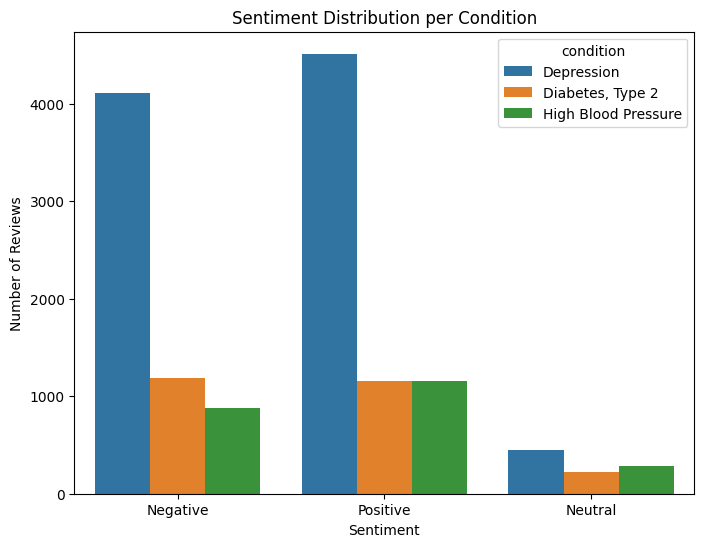

In [32]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', hue='condition', data=df)
plt.title('Sentiment Distribution per Condition')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [33]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,review_length,cleaned,sentiment
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,2017-03-09,54,80,i taken antidepress year improv mostli moder s...,Negative
31,96233,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8,2011-05-07,3,51,1 week zoloft anxieti mood swing take 50mg mor...,Positive
44,121333,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4,2016-04-27,3,136,my gp start venlafaxin yesterday help depress ...,Positive
50,156544,Dulaglutide,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l...",10,2017-10-24,24,147,hey guy 4 month sinc last post want give month...,Positive
67,131909,Effexor XR,Depression,"""This medicine saved my life. I was at my wits...",10,2013-06-20,166,106,thi medicin save life wit end antidepress read...,Positive


In [34]:
df.groupby(["rating","sentiment"]).size()

rating  sentiment
1       Negative     1168
        Neutral       149
        Positive      485
2       Negative      362
        Neutral        55
        Positive      228
3       Negative      287
        Neutral        45
        Positive      250
4       Negative      226
        Neutral        30
        Positive      202
5       Negative      341
        Neutral        49
        Positive      366
6       Negative      307
        Neutral        50
        Positive      323
7       Negative      426
        Neutral        59
        Positive      510
8       Negative      739
        Neutral       114
        Positive      942
9       Negative      960
        Neutral       147
        Positive     1361
10      Negative     1353
        Neutral       258
        Positive     2152
dtype: int64

In [35]:
df

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,review_length,cleaned,sentiment
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,2017-03-09,54,80,i taken antidepress year improv mostli moder s...,Negative
31,96233,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8,2011-05-07,3,51,1 week zoloft anxieti mood swing take 50mg mor...,Positive
44,121333,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4,2016-04-27,3,136,my gp start venlafaxin yesterday help depress ...,Positive
50,156544,Dulaglutide,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l...",10,2017-10-24,24,147,hey guy 4 month sinc last post want give month...,Positive
67,131909,Effexor XR,Depression,"""This medicine saved my life. I was at my wits...",10,2013-06-20,166,106,thi medicin save life wit end antidepress read...,Positive
...,...,...,...,...,...,...,...,...,...,...
161251,198130,Metoprolol,High Blood Pressure,"""It is fourth blood pressure pill for me. It f...",4,2009-07-15,39,36,it fourth blood pressur pill me feel like part...,Negative
161258,34443,Bystolic,High Blood Pressure,"""While on Bystolic my feet and arms were numb....",1,2009-07-18,25,70,while bystol foot arm numb blood sugar becam s...,Negative
161278,86533,Invokana,"Diabetes, Type 2","""I just got diagnosed with type 2. My doctor p...",9,2015-10-23,47,40,i got diagnos type 2 doctor prescrib invokana ...,Negative
161286,93069,Vortioxetine,Depression,"""This is the third med I&#039;ve tried for anx...",2,2016-07-17,33,47,thi third med tri anxieti mild depress week ha...,Negative


In [36]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder

X = df['cleaned']
y = df['condition']
le = LabelEncoder()
y_encoded = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train





39717     had take zoloft 50mg year life stress increas ...
84429                          caus fatigu leg cramp nausea
51457     thi 6th day lexapro appetit start feel less an...
82180     take medicin three month year live mildmoder d...
107299    i took medicin 2 year ago month hypertens medi...
                                ...                        
59996     have afreeza 2 month took month number target ...
155349                                                 good
62492     i final gut mention depress doctor thank god d...
9510      i take medicin sinc age 46 60 although steadil...
83658     prozac medicin me put prozac depress actual be...
Name: cleaned, Length: 11155, dtype: object

In [37]:

X_test

98747     i pretti much everi antidepress there noth rea...
42759     take almost 2 month research realiz me feel wo...
152632    viibryd 7 day great 10mg right move 20mg next ...
65985     doctor gave worth sampl get sugar read down 3 ...
87628     i deal anxieti depress year got prescrib xanax...
                                ...                        
56118     lexapro 2 week feel amaz anxieti decreas mood ...
108500    i experienc terribl wake headach also abl thin...
77466     i take effexor sinc first came out drug help m...
145764    i high blood pressur five year includ treatmen...
142719    i 46 yr old taken effexor sinc 2000 help balan...
Name: cleaned, Length: 2789, dtype: object

In [38]:
y_train

array([0, 2, 0, ..., 0, 2, 0])

In [39]:
y_test

array([0, 0, 0, ..., 0, 2, 0])

In [40]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1,1)  # Unigrams only
)
X_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_tfidf_array = X_tfidf.toarray()

# Feature names (words/terms)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Example: Print feature matrix
import pandas as pd
df_tfidf = pd.DataFrame(X_tfidf_array, columns=feature_names)
print(df_tfidf)

        05  05mg   06   10  100  1000  1000mg  100mg  1010  1012  ...  \
0      0.0   0.0  0.0  0.0  0.0   0.0     0.0    0.0   0.0   0.0  ...   
1      0.0   0.0  0.0  0.0  0.0   0.0     0.0    0.0   0.0   0.0  ...   
2      0.0   0.0  0.0  0.0  0.0   0.0     0.0    0.0   0.0   0.0  ...   
3      0.0   0.0  0.0  0.0  0.0   0.0     0.0    0.0   0.0   0.0  ...   
4      0.0   0.0  0.0  0.0  0.0   0.0     0.0    0.0   0.0   0.0  ...   
...    ...   ...  ...  ...  ...   ...     ...    ...   ...   ...  ...   
11150  0.0   0.0  0.0  0.0  0.0   0.0     0.0    0.0   0.0   0.0  ...   
11151  0.0   0.0  0.0  0.0  0.0   0.0     0.0    0.0   0.0   0.0  ...   
11152  0.0   0.0  0.0  0.0  0.0   0.0     0.0    0.0   0.0   0.0  ...   
11153  0.0   0.0  0.0  0.0  0.0   0.0     0.0    0.0   0.0   0.0  ...   
11154  0.0   0.0  0.0  0.0  0.0   0.0     0.0    0.0   0.0   0.0  ...   

       yourself   yr  zap  zapsquot  zero  zofran    zoloft  zombi  zone  \
0           0.0  0.0  0.0       0.0   0.0     0

In [41]:
accuracies_training=[]
accuracies_testing=[]

In [42]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])


param_grid = {
    # TF-IDF Hyperparameters
    'tfidf__max_features': [1000000],
    'tfidf__ngram_range': [ (1, 2),(1,1),(2,2)],
    # Logistic Regression Hyperparameters
    'clf__C': [0.01, 0.1, 1, 10, 100],
}



grid_log= GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_log.fit(X_train, y_train)

y_pred_log= grid_log.predict(X_test)
y_train_pred_log=grid_log.predict(X_train)

print("Best Parameters:", grid_log.best_params_)
print("test Accuracy:", accuracy_score(y_test, y_pred_log))
print("training accuracy",accuracy_score(y_train,y_train_pred_log))

print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters: {'clf__C': 10, 'tfidf__max_features': 1000000, 'tfidf__ngram_range': (1, 1)}
test Accuracy: 0.969881678020796
training accuracy 0.9965038099506948

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1800
           1       0.98      0.94      0.96       501
           2       0.96      0.91      0.94       488

    accuracy                           0.97      2789
   macro avg       0.97      0.95      0.96      2789
weighted avg       0.97      0.97      0.97      2789



In [43]:
accuracies_training.append({"model": "LogisticRegression", "Train": accuracy_score(y_train, y_train_pred_log)})
accuracies_testing.append({"model": "LogisticRegression", "Test": accuracy_score(y_test, y_pred_log)})

In [44]:
# Define a function to plot confusion matrix
def confusion_matrix_fun(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

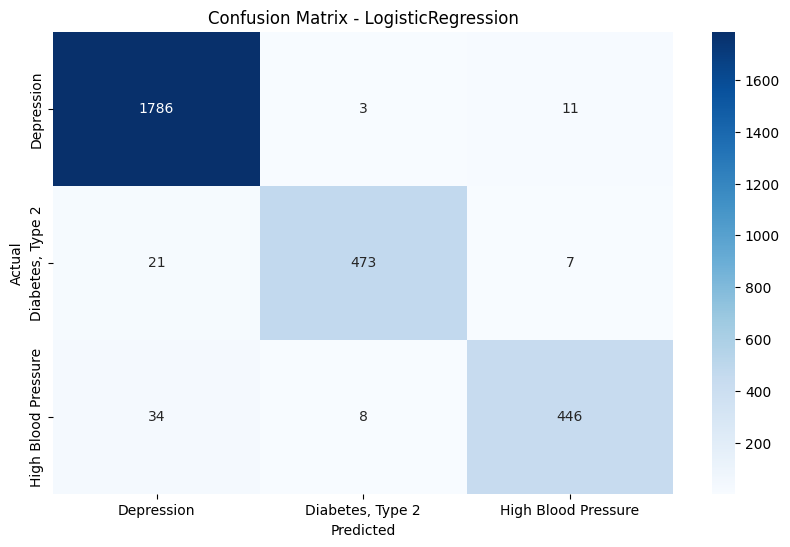

In [45]:
confusion_matrix_fun(y_test,y_pred_log,"LogisticRegression")

Best Parameters: {'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__lowercase': True, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True


In [46]:
from sklearn.svm import LinearSVC
pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LinearSVC())
])
param_grid_svm = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__ngram_range': [(1,1), (1,2),(1,3)],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__max_iter': [1000, 2000, 5000]
}

grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=3, n_jobs=-1, verbose=1)
grid_svm.fit(X_train, y_train)
y_pred_svm = grid_svm.predict(X_test)
y_train_pred_svm=grid_svm.predict(X_train)

accuracies_training.append({"model": "LinearSVC", "Train": accuracy_score(y_train,y_train_pred_svm)})
accuracies_testing.append({"model": "LinearSVC", "Test": accuracy_score(y_test, y_pred_svm)})
print("Best Parameters:", grid_svm.best_params_)
print("test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("training accuracy",accuracy_score(y_train,y_train_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'clf__C': 1, 'clf__max_iter': 1000, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}
test Accuracy: 0.9612764431695948
training accuracy 0.9962348722545944

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1800
           1       0.97      0.95      0.96       501
           2       0.94      0.88      0.91       488

    accuracy                           0.96      2789
   macro avg       0.96      0.94      0.95      2789
weighted avg       0.96      0.96      0.96      2789



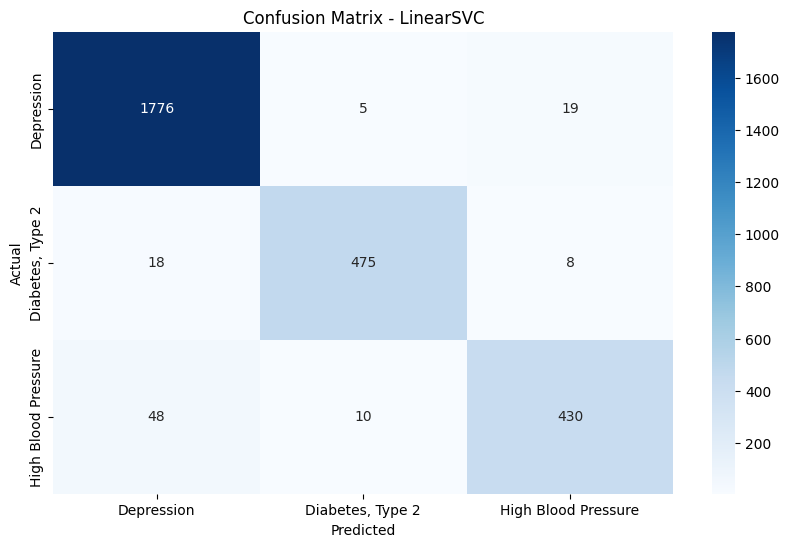

In [47]:
confusion_matrix_fun(y_test, y_pred_svm,"LinearSVC")

In [48]:
from sklearn.naive_bayes import MultinomialNB

pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

param_grid_nb = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__ngram_range': [(1,1), (2,2)],
    'clf__alpha': [0.5, 1.0, 1.5]  
}

grid_nb = GridSearchCV(pipe_nb, param_grid_nb, cv=3, n_jobs=-1, verbose=1)
grid_nb.fit(X_train, y_train)
y_pred_mnb= grid_nb.predict(X_test)
y_train_pred_mnb=grid_nb.predict(X_train)
accuracies_training.append({"model": "Multinomial Naive Bayes", "Train": accuracy_score(y_train,y_train_pred_mnb)})
accuracies_testing.append({"model": "Multinomial Naive Bayes", "Test": accuracy_score(y_test, y_pred_mnb)})

print("Best Parameters:", grid_nb.best_params_)
print("test Accuracy:", accuracy_score(y_test, y_pred_mnb))
print("training accuracy",accuracy_score(y_train,y_train_pred_mnb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_mnb))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'clf__alpha': 0.5, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}
test Accuracy: 0.9411975618501255
training accuracy 0.9508740475123263

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      1800
           1       0.97      0.90      0.93       501
           2       0.96      0.79      0.87       488

    accuracy                           0.94      2789
   macro avg       0.95      0.89      0.92      2789
weighted avg       0.94      0.94      0.94      2789



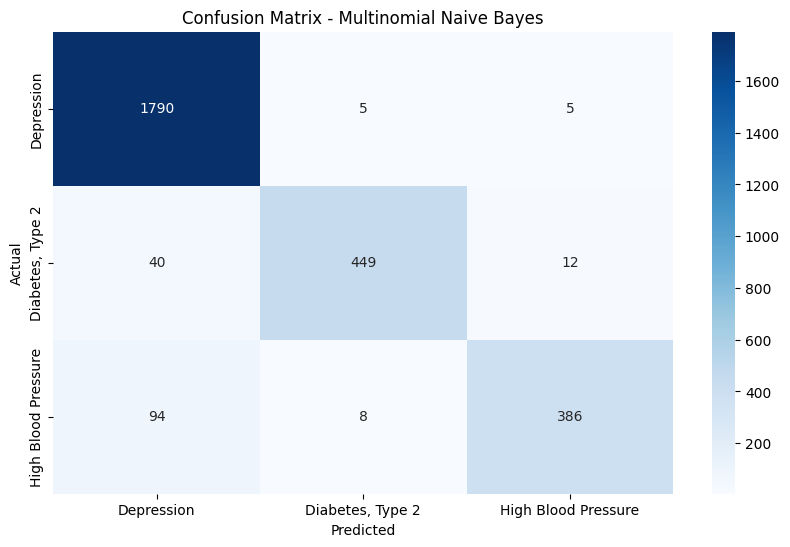

In [49]:
confusion_matrix_fun(y_test, y_pred_mnb,"Multinomial Naive Bayes")

In [50]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

param_grid_rf = {
    'tfidf__max_features': [3000],
    'tfidf__ngram_range': [(1,1)],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None]
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=3, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
y_train_pred_rf=grid_rf.predict(X_train)
accuracies_training.append({"model": "RandomForestClassifier", "Train": accuracy_score(y_train,y_train_pred_rf)})
accuracies_testing.append({"model": "RandomForestClassifier", "Test": accuracy_score(y_test, y_pred_rf)})
print("Best Parameters:", grid_rf.best_params_)
print("test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("training accuracy",accuracy_score(y_train,y_train_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'clf__max_depth': None, 'clf__n_estimators': 200, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}
test Accuracy: 0.9655790605951954
training accuracy 0.9996414164051994

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1800
           1       0.99      0.93      0.96       501
           2       0.97      0.90      0.93       488

    accuracy                           0.97      2789
   macro avg       0.97      0.94      0.96      2789
weighted avg       0.97      0.97      0.97      2789



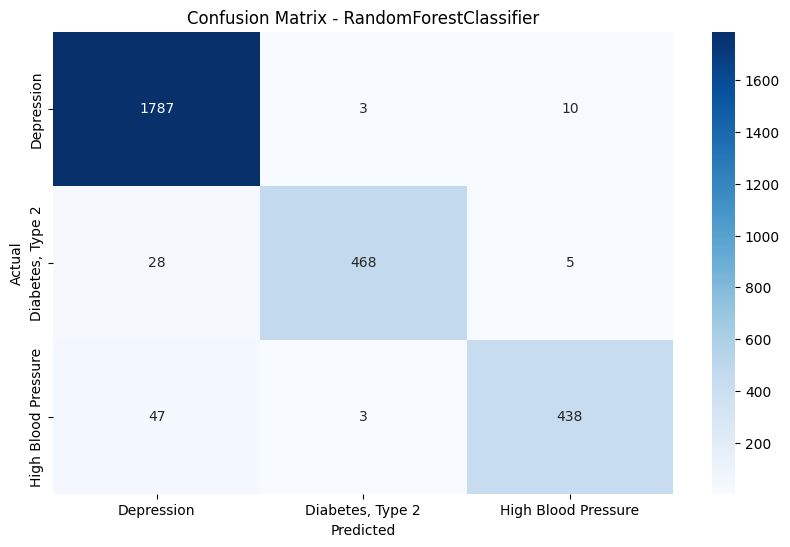

In [51]:
confusion_matrix_fun(y_test, y_pred_rf,"RandomForestClassifier")

In [52]:

from sklearn.ensemble import  VotingClassifier



# Common TF-IDF settings
tfidf = TfidfVectorizer(stop_words='english')

# === Individual Models ===
log_reg = LogisticRegression(max_iter=1000)
svc = LinearSVC()
rf = RandomForestClassifier()

# === Combine Models Using VotingClassifier ===
voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg),
    ('svc', svc),
    ('rf', rf)
], voting='hard')  # 'hard' for majority class voting, 'soft' for probability voting

# === Create Pipeline ===
pipe_voting = Pipeline([
    ('tfidf', tfidf),
    ('clf', voting_clf)
])

# === Hyperparameter Tuning Using GridSearchCV ===
param_grid_voting = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__log_reg__C': [0.1, 1, 10],
    'clf__svc__C': [0.1, 1, 10],
    'clf__rf__n_estimators': [100, 200],
    'clf__rf__max_depth': [10, 20, None]
}

grid_voting = GridSearchCV(pipe_voting, param_grid_voting, cv=3, n_jobs=-1, verbose=2)
grid_voting.fit(X_train, y_train)

# Best Parameters
print("\nBest Parameters:", grid_voting.best_params_)

# Predictions
y_pred_voting = grid_voting.predict(X_test)
y_train_pred_voting=grid_voting.predict(X_train)
accuracies_training.append({"model": "VotingClassifier", "Train": accuracy_score(y_train,y_train_pred_voting)})
accuracies_testing.append({"model": "VotingClassifier", "Test": accuracy_score(y_test, y_pred_voting)})

# Evaluate Model
print(" test Accuracy:", accuracy_score(y_test, y_pred_voting))
print("training accuracy",accuracy_score(y_train,y_train_pred_voting))
print(classification_report(y_test, y_pred_voting))


Fitting 3 folds for each of 216 candidates, totalling 648 fits

Best Parameters: {'clf__log_reg__C': 10, 'clf__rf__max_depth': None, 'clf__rf__n_estimators': 100, 'clf__svc__C': 1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}
 test Accuracy: 0.9688060236643958
training accuracy 0.9948901837740923
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1800
           1       0.97      0.94      0.96       501
           2       0.95      0.92      0.93       488

    accuracy                           0.97      2789
   macro avg       0.97      0.95      0.96      2789
weighted avg       0.97      0.97      0.97      2789



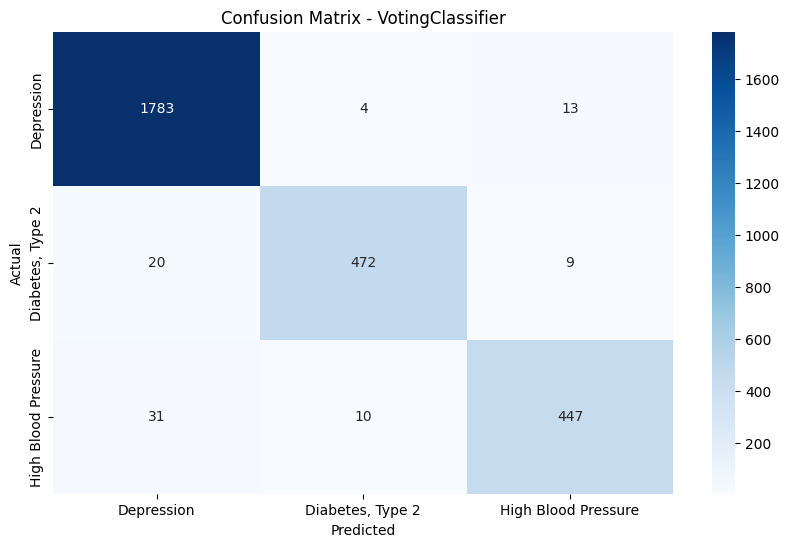

In [53]:
confusion_matrix_fun(y_test, y_pred_voting,"VotingClassifier")

In [54]:
accuracies_training

[{'model': 'LogisticRegression', 'Train': 0.9965038099506948},
 {'model': 'LinearSVC', 'Train': 0.9962348722545944},
 {'model': 'Multinomial Naive Bayes', 'Train': 0.9508740475123263},
 {'model': 'RandomForestClassifier', 'Train': 0.9996414164051994},
 {'model': 'VotingClassifier', 'Train': 0.9948901837740923}]

In [55]:
accuracies_testing

[{'model': 'LogisticRegression', 'Test': 0.969881678020796},
 {'model': 'LinearSVC', 'Test': 0.9612764431695948},
 {'model': 'Multinomial Naive Bayes', 'Test': 0.9411975618501255},
 {'model': 'RandomForestClassifier', 'Test': 0.9655790605951954},
 {'model': 'VotingClassifier', 'Test': 0.9688060236643958}]

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame for training accuracies
df_train = pd.DataFrame(accuracies_training)

# Create DataFrame for testing accuracies
df_test = pd.DataFrame(accuracies_testing)

# Merge both DataFrames on 'model' column
results = pd.merge(df_train, df_test, on='model')
results



,model,Train,Test
0,LogisticRegression,0.996504,0.969882
1,LinearSVC,0.996235,0.961276
2,Multinomial Naive Bayes,0.950874,0.941198
3,RandomForestClassifier,0.999641,0.965579
4,VotingClassifier,0.994890,0.968806


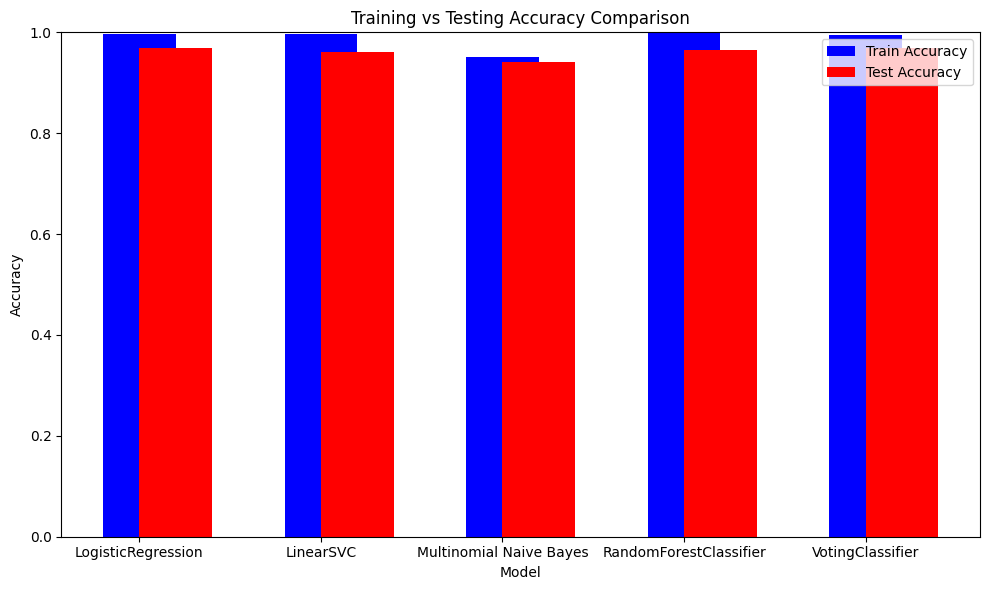

In [57]:
# Plot the data
plt.figure(figsize=(10, 6))

# Plotting the training and testing accuracies for each model
plt.bar(results['model'], results['Train'], width=0.4, label='Train Accuracy', align='center', color='b')
plt.bar(results['model'], results['Test'], width=0.4, label='Test Accuracy', align='edge', color='r')

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy Comparison')
plt.ylim(0, 1)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


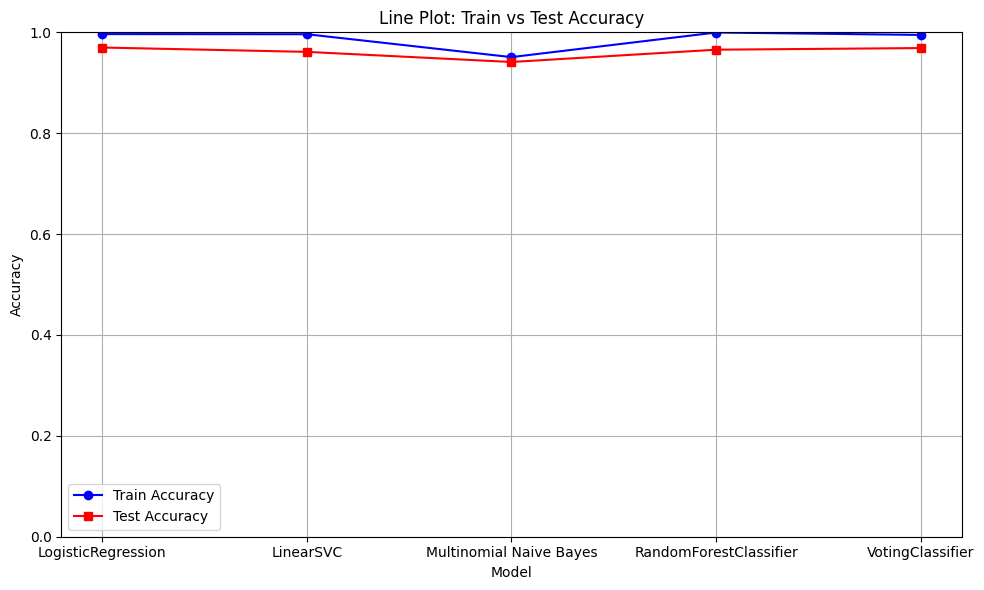

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(results['model'], results['Train'], marker='o', label='Train Accuracy', color='blue')
plt.plot(results['model'], results['Test'], marker='s', label='Test Accuracy', color='red')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Line Plot: Train vs Test Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Best Model: LogisticRegression


In [59]:
def predict_condition(review):
    cleaned_review = clean_review_with_stop_and_stem(review)
    predicted_label = grid_log.predict([cleaned_review])[0]  # raw text goes directly here
    predicted_condition = le.inverse_transform([predicted_label])[0]
    return predicted_condition


new_review = "I've been feeling very down lately and have lost interest in activities I used to enjoy."
predicted_condition = predict_condition(new_review)
print(f"Predicted condition for the review: {predicted_condition}")

Predicted condition for the review: Depression


In [60]:
df[df["Unnamed: 0"]==103458]

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,review_length,cleaned,sentiment
161290,103458,Tekturna,High Blood Pressure,"""I have only been on Tekturna for 9 days. The ...",7,2010-02-07,18,72,i tekturna 9 day effect immedi also calcium ch...,Negative


In [61]:
review=df[df["Unnamed: 0"]==103458].review
print(f"Predicted condition for the review: {predict_condition(review)}")

Predicted condition for the review: High Blood Pressure
